In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
stock = yf.Ticker("AAPL") 
data = stock.history(start="2015-01-01", end="2025-01-01", auto_adjust=False) 

In [3]:
df = data.reset_index()['Close']

In [4]:
df = df.rolling(window=3).mean().dropna()

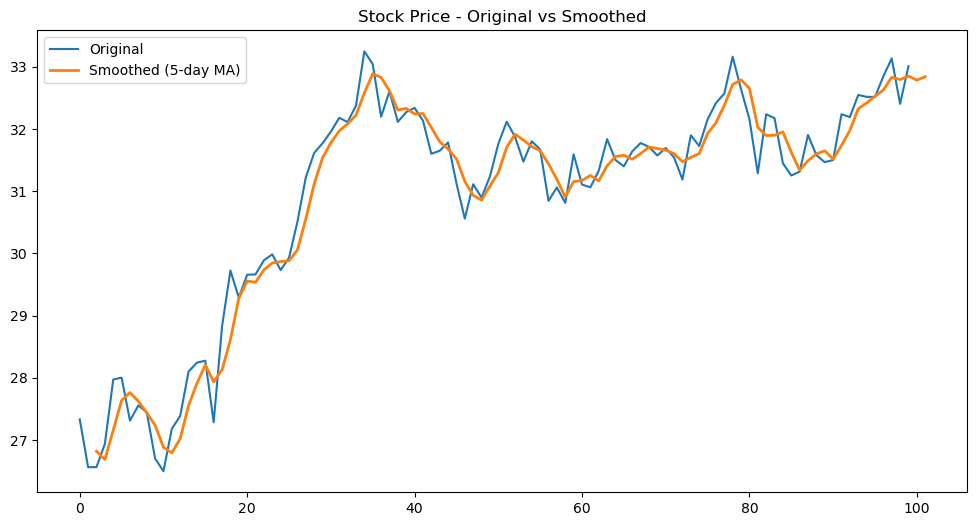

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data.reset_index()['Close'][:100], label='Original')
plt.plot(df[:100], label='Smoothed (5-day MA)', linewidth=2)
plt.legend()
plt.title("Stock Price - Original vs Smoothed")
plt.show()

In [6]:
training_size = int(len(df)*0.8)
train_data = df[:training_size]
test_data = df[training_size:]

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data_scaled = scaler.transform(np.array(test_data).reshape(-1, 1))

In [8]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [9]:
time_step = 100
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, ytest = create_dataset(test_data_scaled, time_step)

In [10]:
print(X_train.shape), print(y_train.shape)

(1911, 100)
(1911,)


(None, None)

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input
from tensorflow.keras.layers import Dropout

In [13]:
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [14]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam


model.compile(
    loss=Huber(delta=1.0),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mae']
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, ytest),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0473 - mae: 0.2068 - val_loss: 0.0057 - val_mae: 0.0834 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0035 - mae: 0.0663 - val_loss: 0.0056 - val_mae: 0.0845 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0022 - mae: 0.0457 - val_loss: 0.0033 - val_mae: 0.0652 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0021 - mae: 0.0419 - val_loss: 0.0034 - val_mae: 0.0664 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0017 - mae: 0.0375 - val_loss: 0.0047 - val_mae: 0.0785 - learning_rate: 1.0000e-04
Epoch 6/100
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0017 - mae: 0.0381
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0017 - mae: 0.0381 - val_loss: 0.0035 - val_mae: 0.0670 - learn

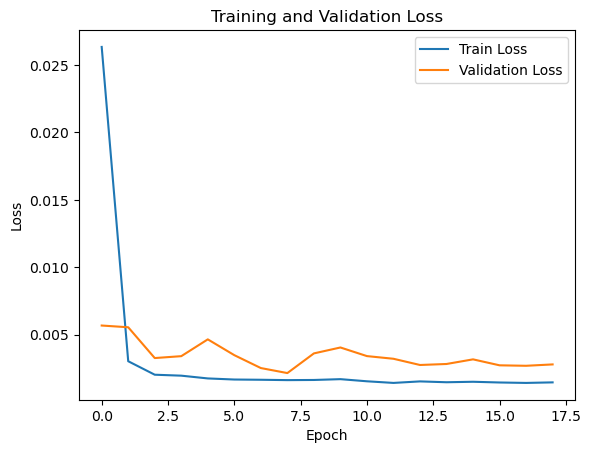

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [17]:
predictions = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [18]:
predictions = scaler.inverse_transform(predictions)

In [19]:
predictions

array([[171.8624 ],
       [172.15318],
       [172.42104],
       [172.6902 ],
       [172.97734],
       [173.2974 ],
       [173.65784],
       [174.05789],
       [174.48201],
       [174.90594],
       [175.32477],
       [175.73923],
       [176.16803],
       [176.61568],
       [177.08571],
       [177.57758],
       [178.0873 ],
       [178.60861],
       [179.12318],
       [179.63118],
       [180.13275],
       [180.62698],
       [181.11235],
       [181.59384],
       [182.08319],
       [182.59721],
       [183.13937],
       [183.70503],
       [184.2735 ],
       [184.8271 ],
       [185.34741],
       [185.81532],
       [186.22711],
       [186.59337],
       [186.92816],
       [187.25087],
       [187.57462],
       [187.9144 ],
       [188.26178],
       [188.60344],
       [188.92516],
       [189.22609],
       [189.51515],
       [189.79288],
       [190.06631],
       [190.34113],
       [190.62344],
       [190.89618],
       [191.13509],
       [191.2863 ],


In [20]:
y_test_actual = scaler.inverse_transform(ytest.reshape(-1, 1))

In [21]:
y_test_actual

array([[172.1299998 ],
       [173.41999817],
       [175.24000041],
       [176.65999858],
       [178.21333313],
       [179.42999776],
       [180.20666504],
       [179.91333516],
       [178.87000529],
       [179.20000712],
       [179.78334045],
       [181.77333577],
       [182.68666585],
       [183.68332926],
       [184.42332967],
       [184.95999654],
       [185.31332906],
       [184.6299998 ],
       [185.32333374],
       [185.8799998 ],
       [186.31666565],
       [186.66999817],
       [187.52666728],
       [188.96666463],
       [190.93666585],
       [192.00666809],
       [192.58666992],
       [191.8666687 ],
       [191.27333069],
       [190.36666361],
       [189.12333171],
       [188.82000224],
       [189.46333313],
       [190.33333333],
       [191.74000041],
       [192.80333455],
       [194.27333577],
       [193.9866689 ],
       [193.39000448],
       [192.60666911],
       [192.76999919],
       [193.62333171],
       [193.77999878],
       [194

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

RMSE: 10.309679706637924
MAE: 8.403053769599907
R² Score: 0.8063422685386938


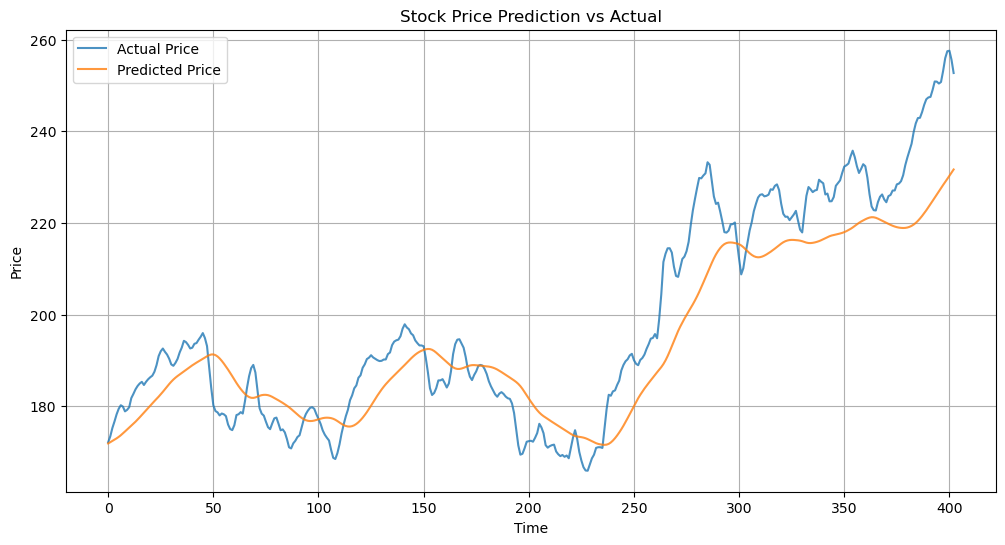

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', alpha=0.8)
plt.plot(predictions, label='Predicted Price', alpha=0.8)
plt.title('Stock Price Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import os

folder = 'models/exp1'
os.makedirs(folder, exist_ok=True)  

model.save(os.path.join(folder, 'my_model.h5'))

In [25]:
model.save('models/exp1/my_model.keras') 